# Problem Set 5: Profit Diagram and Breakeven Points for a Short Strangle
A short strangle is an [advanced trading strategy](https://www.tastylive.com/concepts-strategies/strangle) that involves selling both a call and a put option on the same underlying stock. In this strategy, both options have the same expiration date but different strike prices. 

> __Learning Objectives:__
> 
> By the end of this problem set, you will be able to:
> * Build contract models for multi-leg options strategies using real market data and compute profit diagrams showing the payoff structure across a range of potential share prices at expiration.
> * Calculate analytical breakeven points for a short strangle and interpret the profit and loss regions on the profit diagram.
> * Apply cumulative distribution functions to estimate the probability of profit and various outcome scenarios using both geometric Brownian motion and implied volatility-based models for future share price distributions.

Let's get started!
___

## Setup, Data, and Prerequisites
First, we set up the computational environment by including the `Include.jl` file and loading any needed resources.

> __Include:__ The [`include(...)` command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file, `Include.jl`, in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, etc. For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

Let's set up our code environment:

In [1]:
include(joinpath(@__DIR__, "Include.jl")); # include the Include.jl file

For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl).

### Data
To start, load the options data using [the `MyOptionsChainDataSet(...)` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/data/#VLQuantitativeFinancePackage.MyOptionsChainDataSet) and store the metadata in the `metadata::Dict{String,Any}` variable and the options chain data in the `optionschain::DataFrame` variable.

In [2]:
metadata, optionschain = let
    
    # initialize -
    options_dataset = MyOptionsChainDataSet(ticker="amd");
    metadata = options_dataset.metadata;
    optionschain = options_dataset.data;

    (metadata, optionschain) # return
end;

What's in the `metadata::Dict{String,Any}` dictionary?

In [3]:
metadata |> keys

KeySet for a Dict{String, Any} with 10 entries. Keys:
  "DTE"
  "purchase_date"
  "historical_volatility"
  "underlying_share_price_ask"
  "source"
  "underlying_share_price_bid"
  "is_weekly"
  "atm_IV"
  "expiration_date"
  "underlying_share_price_mid"

What about the `optionschain::DataFrame` variable?

In [4]:
optionschain

Row,Strike,Moneyness,Bid,Mid,Ask,Last,Volume,Open Int,IV,Delta,Type
,Float64,Float64,Float64,Float64,Float64,Float64,String7,String7,Float64,Float64,String7
1,25.0,0.8907,203.1,204.0,204.9,209.72,0,419,2.1122,0.9989,Call
2,30.0,0.8688,198.2,199.05,199.9,206.3,0,163,1.9784,0.9985,Call
3,35.0,0.847,193.2,193.98,194.75,199.75,0,17,0.0,0.0,Call
4,40.0,0.8251,188.3,189.1,189.9,176.24,0,18,1.6654,0.9985,Call
5,45.0,0.8033,183.25,184.13,185.0,174.11,0,318,1.5375,0.9985,Call
6,50.0,0.7814,178.4,179.1,179.8,167.46,0,691,1.2356,0.9996,Call
7,55.0,0.7596,173.35,174.13,174.9,177.43,0,176,1.0885,0.9998,Call
8,60.0,0.7377,168.5,169.3,170.1,162.15,0,332,1.3802,0.9967,Call
9,65.0,0.7158,163.45,164.33,165.2,175.38,0,180,1.2927,0.9967,Call


In [5]:
let
        
        # initialize -
        δ = 0.5; # set the delta for ATM search
        options_chain = optionschain;
        Sₒ = metadata["underlying_share_price_mid"] |> x-> parse(Float64, x) # mid underlying price on purchase date, 10-22-2025

        # Next, let's find contracts that are at-the-money (ATM) or near-the-money (NTM) -
        atm_call_options = filter(row -> abs((row[:Strike] - Sₒ)/Sₒ) < δ, options_chain);
end

Row,Strike,Moneyness,Bid,Mid,Ask,Last,Volume,Open Int,IV,Delta,Type
,Float64,Float64,Float64,Float64,Float64,Float64,String7,String7,Float64,Float64,String7
1,115.0,0.4972,114.4,114.98,115.55,121.33,0,"3,187",0.8688,0.9853,Call
2,120.0,0.4754,109.65,110.1,110.55,109.75,1,"5,468",0.7294,0.9915,Call
3,125.0,0.4535,104.65,105.2,105.75,105.85,10,"5,090",0.8135,0.9796,Call
4,130.0,0.4317,99.9,100.35,100.8,98.6,2,"3,540",0.7909,0.9756,Call
5,135.0,0.4098,95.25,95.65,96.05,96.69,4,"3,604",0.7897,0.9681,Call
6,140.0,0.388,90.25,90.7,91.15,92.35,46,"4,005",0.7459,0.9658,Call
7,145.0,0.3661,85.45,85.93,86.4,85.15,33,"2,295",0.7261,0.9593,Call
8,150.0,0.3442,80.75,81.23,81.7,79.6,92,"6,619",0.7115,0.9508,Call
9,155.0,0.3224,76.2,76.55,76.9,77.8,3,"4,606",0.6951,0.9415,Call


### Constants
Let's set a value for the step size `Δt::Float64`, i.e., `1 day` in units of years (assuming a `365-day` year), and the risk-free rate at the time we gathered the data for the option contracts; we approximate this value using the [yield on the 10-year Treasury Note](https://ycharts.com/indicators/10_year_treasury_rate). We also set a value for the underlying share price `Sₒ::Float64`, the number of levels in the binomial tree model `h::Int64`, the strike price `K::Float64`, and the direction parameter `θ::Int64`; we assume 6 levels per day.

In [6]:
Sₒ = metadata["underlying_share_price_mid"] |> x-> parse(Float64, x); # mid underlying price on purchase date, 10-22-2025

Other constants:

In [7]:
Δt = (1/365); # options use 365 day year
DTE = metadata["DTE"] |> x-> parse(Float64, x); # days to expiration (units: days)
risk_free_rate = 0.0407; # yield 10-year treasury note on 07-Nov-2025
h = (DTE)*6 |> x-> floor(Int, x); # 6-points per trading day
θ = -1; # 1 = long strangle, -1 = short strangle
w = 0.5; # width of range to explore. Adjust me to see what happens


In this example, we'll need to do a projection of the future share price distribution at the contract's expiration date. We'll use a Geometric Brownian Motion (GBM) model to project the future share price distribution at expiration.

Let's load the single asset geometric Brownian motion (SAGBM) parameters which we estimated a few lectures ago, which include the drift and diffusion coefficients for each ticker. We'll store this data in the `parameters_df::DataFrame` variable:

In [8]:
parameters_df = let

    # load -
    df = CSV.read(joinpath(_PATH_TO_DATA,"SAGBM-Parameters-Fall-2025.csv"), DataFrame);
    df; # return
end;

We are looking at `MU`, so let's see what the parameters for this ticker are:

In [9]:
filter(:ticker=> x-> x=="MU", parameters_df)

Row,ticker,drift,t,lower_bound_drift,upper_bound_drift,volatility
,String7,Float64,Float64,Float64,Float64,Float64
1,MU,0.159132,1.96,0.156826,0.161439,0.406491


___

## Task 1: Select the strike prices for the call and put legs of the strangle
In this task, we'll select random put and call contracts (from which we construct our strangle) from the `MU` options chain data.
Let the put leg of the strangle have index `1`, and the call leg have index `2`. 

> __Setup__: For our __short strangle__, the put and call legs will bracket the initial share price, i.e., $K_{1}<S_{\circ}<K_{2}$, where $K_{1}$ is the strike price for the put leg, $K_{2}$ is the strike price for the call leg, and $S_{\circ}$ is the initial share price (price of the underlying asset when we initiate the position).

Let's select random strike prices for the put and call legs such that the $K_{1}<S_{\circ}<K_{2}$ inequality is true.

Starting with the put contracts, filter the `dataset` to find the put contracts such that $\left(1-w\right)\cdot{S}_{\circ}\leq{K_{1}}<S_{\circ}$, where the $w>0$ value is specified above. This will give put contracts with strikes less than the initial share price but not too far away from the money.

We'll use the [filter function](https://dataframes.juliadata.org/stable/lib/functions/#Base.filter) exported by the [DataFrames.jl package](https://github.com/JuliaData/DataFrames.jl) in combination with the [Julia pipe operator](https://docs.julialang.org/en/v1/manual/functions/#Function-composition-and-piping). Save the filtered selection of put contracts in the `put_contracts::DataFrame` variable:

In [10]:
put_contracts = let
    dataset = optionschain;
    contracts = filter(:Type=>x->x == "Put", dataset) |> y -> filter(:Strike=> x-> (x < Sₒ && x ≥ (1-w)*Sₒ), y)
    
    # Add error handling for empty contract lists
    if nrow(contracts) == 0
        error("No suitable put contracts found. Try increasing the 'w' parameter above to expand the search range.")
    end
    
    println("✓ Found $(nrow(contracts)) put contracts in range [$(round((1-w)*Sₒ, digits=2)), $(round(Sₒ, digits=2))]")
    contracts
end;

✓ Found 20 put contracts in range [112.89, 225.78]


In [11]:
put_contracts

Row,Strike,Moneyness,Bid,Mid,Ask,Last,Volume,Open Int,IV,Delta,Type
,Float64,Float64,Float64,Float64,Float64,Float64,String7,String7,Float64,Float64,String7
1,115.0,-0.4972,0.38,0.4,0.41,0.4,9,"6,161",0.8485,-0.0132,Put
2,120.0,-0.4754,0.45,0.46,0.48,0.45,94,"8,254",0.8162,-0.0152,Put
3,125.0,-0.4535,0.55,0.56,0.56,0.54,21,"6,269",0.797,-0.0188,Put
4,130.0,-0.4317,0.64,0.65,0.65,0.65,41,"7,361",0.7721,-0.0222,Put
5,135.0,-0.4098,0.76,0.78,0.79,0.72,6,"10,302",0.7506,-0.0267,Put
6,140.0,-0.388,0.91,0.93,0.94,0.94,22,"6,300",0.7325,-0.0323,Put
7,145.0,-0.3661,1.09,1.11,1.13,1.2,138,"8,633",0.7115,-0.0383,Put
8,150.0,-0.3442,1.32,1.34,1.36,1.4,167,"10,005",0.6947,-0.0461,Put
9,155.0,-0.3224,1.61,1.63,1.65,1.7,56,"3,994",0.6802,-0.0555,Put


Select a random contract from the `put_contracts` collection; this will be our first leg of the strangle. Save the data for this contract in the `put_leg_data` variable, which is type [DataFrameRow](https://dataframes.juliadata.org/stable/lib/types/#DataFrames.DataFrameRow):

In [12]:
put_leg_data = let
    selected = nrow(put_contracts) |> i-> put_contracts[rand(1:i),:] # fancy!
    println("✓ Selected Put: Strike = $(selected[:Strike]), Premium = $(selected[:Mid]), IV = $(round(selected[:IV]*100, digits=1))%")
    selected
end

✓ Selected Put: Strike = 130.0, Premium = 0.65, IV = 77.2%


Row,Strike,Moneyness,Bid,Mid,Ask,Last,Volume,Open Int,IV,Delta,Type
,Float64,Float64,Float64,Float64,Float64,Float64,String7,String7,Float64,Float64,String7
4,130.0,-0.4317,0.64,0.65,0.65,0.65,41,"7,361",0.7721,-0.0222,Put


Next, do the same procedure for the call contracts. Filter `dataset` to find the call contracts with the property $S_{\circ}<K_{2}\leq\left(1+w\right)\cdot{S}_{\circ}$ where $w>0$ is specified above. To do this, we'll use the [filter function](https://dataframes.juliadata.org/stable/lib/functions/#Base.filter) exported by the [DataFrames.jl package](https://github.com/JuliaData/DataFrames.jl) in combination with the [Julia pipe operator](https://docs.julialang.org/en/v1/manual/functions/#Function-composition-and-piping).

Save the filtered selection of call contracts in the `call_contracts::DataFrame` variable:

In [13]:
call_contracts = let
    dataset = optionschain;
    contracts = filter(:Type=>x->x == "Call", dataset) |> y -> filter(:Strike=> x-> (x > Sₒ && x ≤ (1+w)*Sₒ), y)
    
    # Add error handling for empty contract lists
    if nrow(contracts) == 0
        error("No suitable call contracts found. Try increasing the 'w' parameter above to expand the search range.")
    end
    
    println("✓ Found $(nrow(contracts)) call contracts in range [$(round(Sₒ, digits=2)), $(round((1+w)*Sₒ, digits=2))]")
    contracts
end;

✓ Found 11 call contracts in range [225.78, 338.67]


In [14]:
call_contracts

Row,Strike,Moneyness,Bid,Mid,Ask,Last,Volume,Open Int,IV,Delta,Type
,Float64,Float64,Float64,Float64,Float64,Float64,String7,String7,Float64,Float64,String7
1,230.0,-0.0055,21.5,21.58,21.65,21.4,632,"8,311",0.5912,0.5488,Call
2,240.0,-0.0492,17.3,17.35,17.4,17.41,473,"8,889",0.5896,0.4766,Call
3,250.0,-0.0929,13.75,13.83,13.9,13.75,"3,670","9,091",0.5866,0.4072,Call
4,260.0,-0.1367,10.9,10.98,11.05,10.95,480,"7,116",0.5891,0.3446,Call
5,270.0,-0.1804,8.65,8.7,8.75,8.6,283,"4,360",0.5925,0.2891,Call
6,280.0,-0.2241,6.8,6.88,6.95,6.88,154,"3,193",0.5958,0.2405,Call
7,290.0,-0.2678,5.4,5.45,5.5,5.4,84,"3,922",0.5981,0.1981,Call
8,300.0,-0.3115,4.3,4.35,4.4,4.3,"2,911","5,859",0.6038,0.1638,Call
9,310.0,-0.3553,3.4,3.45,3.5,3.35,125,"2,120",0.6106,0.1357,Call


Select a random contract from the `call_contracts::DataFrames` collection; this will be our second leg of the strangle. Save the data for this contract in the `call_leg_data` variable, which is type [DataFrameRow](https://dataframes.juliadata.org/stable/lib/types/#DataFrames.DataFrameRow):

In [15]:
call_leg_data = let
    selected = nrow(call_contracts) |> i-> call_contracts[rand(1:i),:] # fancy!
    println("✓ Selected Call: Strike = $(selected[:Strike]), Premium = $(selected[:Mid]), IV = $(round(selected[:IV]*100, digits=1))%")
    selected
end

✓ Selected Call: Strike = 310.0, Premium = 3.45, IV = 61.1%


Row,Strike,Moneyness,Bid,Mid,Ask,Last,Volume,Open Int,IV,Delta,Type
,Float64,Float64,Float64,Float64,Float64,Float64,String7,String7,Float64,Float64,String7
9,310.0,-0.3553,3.4,3.45,3.5,3.35,125,"2,120",0.6106,0.1357,Call


__Quick Check__: Look at your selected strikes above. The put strike should be _below_ the current stock price, and the call strike should be _above_ it. The difference between them determines the __width of your strangle__.
___

## Task 2: Build contract models and compute the profit and breakeven values at expiration
In this task, let's compute the profit and breakeven values for our short strangle position constructed from the two random contracts selected in Task 1.
Now that we have data for the contracts, we can compute the composite contract profit and breakeven values for the short strangle constructed from the randomly selected put and call legs.

> __Strategy:__ First, [create `MyAmericanPutContractModel` and `MyAmericanCallContractModel` models](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#American-option-contracts), initialized using the data from the random contracts from Task 1. Then, these contract models and possible share prices at expiration are passed to [the `payoff(...)` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.payoff), which computes the individual and composite payoff and profit values.

Start with the put contract model. Build a [`MyAmericanPutContractModel` instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.MyAmericanPutContractModel) using the put contract data, and store this contract model in the `put_contract_model::MyAmericanPutContractModel` variable. 

To access data from the `DataFrameRow,` pass in the column name of what we want. For example, to get the strike price, you would say: `put_leg_data[:Strike].` For the premium value, use the midpoint value.

In [16]:
put_contract_model = build(MyAmericanPutContractModel, (
        K = put_leg_data[:Strike], # TODO: set the strike price
        premium = put_leg_data[:Mid], # TODO: set the premium value
        sense = θ, # we are short, i.e., we *sold* this contract so sense = -1 
        copy = 1));

Similarly, construct the call contract model. Save the call contract model in the `call_contract_model::MyAmericanCallContractModel` variable:

In [17]:
call_contract_model = build(MyAmericanCallContractModel, (
        K = call_leg_data[:Strike], # TODO: set the strike price
        premium = call_leg_data[:Mid], # TODO: set the premium value
        sense = θ, # we are short, i.e., we *sold* this contract so sense = -1 
        copy = 1));

Next, create an array of values for the share price at expiration. We'll look at a range starting from below $K_{1}$ and ending above $K_{2}$ with `number_of_steps` values. Store these values in the `share_price_array::Array{Float64,1}` variable.

In [18]:
share_price_array = let

    # initialize -
    number_of_steps = 1001; # leave me alone!

    # build a range, then pass that to collect (which gives an array)
    share_price_array = range((1-w)*put_contract_model.K,stop = (1+w)*call_contract_model.K, length = number_of_steps) |> collect;

    # return the data
    share_price_array;
end;

Finally, compute the profit for the short strangle. We compute the profit by [calling the `profit(...)` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.profit) and save the profit values in the `profit_array` variable. The [`profit(...)` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.profit) takes two arguments, the contract models as an array and the share price array.

The `profit_array` will be a `1001`$\times$ `4` array, in which each row is a possible value for the share price at expiration $S_{T}$. Column `1` holds the possible $S_{T}$ values, column `2` holds the profit for the short `put,` column `3` holds the profit for the short `call,` and column `4` holds the overall profit for the composite trade.

In [19]:
profit_array = profit([put_contract_model, call_contract_model], share_price_array);

`Unhide` the code below to see how we visualized the profit and breakeven points for the short strangle.

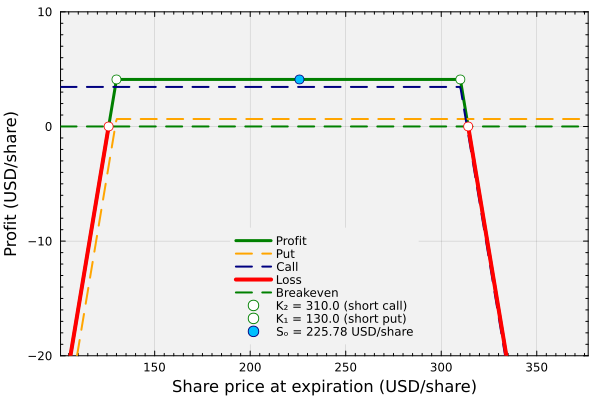

In [20]:
let

    K₁ =  put_leg_data[:Strike];
    K₂ = call_leg_data[:Strike];
    premium_1 = put_leg_data[:Mid]
    premium_2 = call_leg_data[:Mid]
    max_profit = (premium_1 + premium_2);
    
    S = share_price_array
    number_of_steps = length(S);
    BEL = zeros(length(S))

    profit_idx = findall(>(0), profit_array[:,4])
    loss_array = profit_array[:,:]; loss_array[profit_idx,:] .= NaN
    
    breakeven_array = zeros(2,2);
    breakeven_array[1,1] = K₂ + (premium_1 + premium_2);
    breakeven_array[2,1] = K₁ - (premium_1 + premium_2);

    
    plot(profit_array[:,1], profit_array[:,4], lw=3, label="Profit", c=:green, 
        bg="gray95", 	background_color_outside="white", framestyle = :box, fg_legend = :transparent, legend=:bottom, 
        xminorticks=10, yminorticks=10, xlim=(0.8*breakeven_array[2,1],1.2*breakeven_array[1,1]), ylim=(-20,10))
    plot!(profit_array[:,1], profit_array[:,2], lw=2, label="Put", ls=:dash, c=:orange)
    plot!(profit_array[:,1], profit_array[:,3], lw=2, label="Call", ls=:dash, c=:navyblue)
    plot!(loss_array[:,1], loss_array[:,4], lw=4, label="Loss", c=:red)
    
    plot!(S,BEL,lw=2, c=:green, label="Breakeven", ls=:dash)
    scatter!(breakeven_array[:,1], breakeven_array[:,2], c=:white, msc=:red,label="", ms=5)
    
    scatter!([K₂],[max_profit], ms=5, label = "K₂ = $(K₂) (short call)", msc=:green, c=:white)
    scatter!([K₁],[max_profit], ms=5, label = "K₁ = $(K₁) (short put)", msc=:green, c=:white)

    
    # VLINE[1] = Sₒ
    # VLINE[2] .= range(minimum(-1*profit_array[:,end]), stop = maximum(profit_array[:,end]), length = number_of_steps) |> collect;
    scatter!([Sₒ], [max_profit], ms=5, c=:deepskyblue1, msc=:navy, ls=:dash, label="Sₒ = $(Sₒ) USD/share")
    
    xlabel!("Share price at expiration (USD/share)", fontsize=18)
    ylabel!("Profit (USD/share)", fontsize=18)

    # uncomment line below to save figure to disk
    # savefig("Fig-ShortStrangle-PS5-Fall-2024.svg")
end

In [21]:
do_I_see_the_profit_loss_plot = true; # set this value {true | false}

### Breakeven analysis
Compute the breakeven points for the short `MU` strangle. Save these values in the `B_low::Float64` and `B_high::Float64` variables. A strangle has two possible breakeven points at expiration denoted as $B^{+}$ and $B^{-}$:
$$
\begin{equation}
	B(T) = \begin{cases}
		B^{-} = K_{1} - \left(\mathcal{P}_{1}+\mathcal{P}_{2}\right) & S_{T} < K_{1} \\
		B^{+} = K_{2} + \left(\mathcal{P}_{1}+\mathcal{P}_{2}\right) & S_{T} > K_{2}
	\end{cases}
\end{equation}
$$
where $S_{T}$ denotes the share price at expiration, $B^{+}$ denotes the upper breakeven point, $B^{-}$ denotes the lower breakeven point, index $1$ denotes the $\texttt{put}$ contract, index $2$ denotes the $\texttt{call}$ contract; for a strangle $K_{1}<K_{2}$. 

In [22]:
B_low, B_high = let

    # initialize -
    B_low = nothing;
    B_high = nothing;

    # Low - put side
    K₁ = put_contract_model.K;
    P₁ = put_contract_model.premium;

    # High - call side
    K₂ = call_contract_model.K;
    P₂ = call_contract_model.premium;

    # compute -
    B_low = K₁ - (P₁ + P₂);
    B_high = K₂ + (P₁ + P₂);

    # return -
    B_low, B_high
end;

In [ ]:
let
    total_premium = put_contract_model.premium + call_contract_model.premium
    strangle_width = call_contract_model.K - put_contract_model.K
    
    println("Short Strangle Summary:")
    println("   Lower Breakeven (B⁻): $(round(B_low, digits=2)) USD/share")
    println("   Upper Breakeven (B⁺): $(round(B_high, digits=2)) USD/share") 
    println("   Maximum Profit: $(round(total_premium, digits=2)) USD/share")
    println("   Strangle Width: $(round(strangle_width, digits=2)) USD")
    println("   Breakeven Range: $(round(B_high - B_low, digits=2)) USD")
end

📈 Short Strangle Summary:
   Lower Breakeven (B⁻): 125.9 USD/share
   Upper Breakeven (B⁺): 314.1 USD/share
   Maximum Profit: 4.1 USD/share
   Strangle Width: 180.0 USD
   Breakeven Range: 188.2 USD


___

## Task 3: Compute the probability of profit for the random short strangle
In this task, we'll compute the likelihood of various profit levels for the random short-strangle position. To do this, we'll construct models that predict the underlying asset's share price to the contracts' expiration and then use the cumulative distribution function to compute the probability of various conditions being true. 

Let's start by building two models we use to estimate future share price: __Model 1__: geometric Brownian motion (GBM) and __Model 2__: Implied Volatility models.

### Model 1: Geometric Brownian Motion
Build an instance of the [MyGeometricBrownianMotionEquityModel type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.MyGeometricBrownianMotionEquityModel) which holds values for the drift `μ` and volatility `σ` parameters using a [custom build(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.build-Tuple{Type{MyGeometricBrownianMotionEquityModel},%20NamedTuple}). 
* We set the drift parameter to the risk-free rate $\mu = \bar{r}$ (because options use a risk-neutral probability measure), and the volatility is set to the implied volatility estimate $\sigma = \text{IV}$ from the options chain data.
* __Hmmm__. But we have two contracts? Let's use the average `IV` value for two contracts. Alternatively, we could use the average IV value computed over all contracts. Historically, the average IV value for `MU` contracts is around 40% - 50%.

Save the GBM model in the `gbm_model::MyGeometricBrownianMotionEquityModel` variable:

In [46]:
gbm_model, σ̄ = let

    # Step 1: compute the average implied volatility σ̄:
    σ̄ = (1/2)*(call_leg_data[:IV] + put_leg_data[:IV]);
    
    # Display intermediate results
    println("Implied Volatility Analysis:")
    println("   Put IV: $(round(put_leg_data[:IV]*100, digits=1))%")
    println("   Call IV: $(round(call_leg_data[:IV]*100, digits=1))%") 
    println("   Average σ̄: $(round(σ̄*100, digits=1))%")

    # Step 2: build the GBM model
    model = build(MyGeometricBrownianMotionEquityModel, (
        μ = risk_free_rate,
        σ = σ̄
    ));
    
    println("✓ GBM model created with μ = $(round(risk_free_rate*100, digits=2))% and σ = $(round(σ̄*100, digits=1))%")

    model, σ̄
end;

Implied Volatility Analysis:
   Put IV: 77.2%
   Call IV: 61.1%
   Average σ̄: 69.1%
✓ GBM model created with μ = 4.07% and σ = 69.1%


Now that we have a populated [MyGeometricBrownianMotionEquityModel instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.MyGeometricBrownianMotionEquityModel) holding the `AMD` data, let's generate `number_of_samples` possible future share price values using the [sample(...) function exported by the VLQuantitativeFinancePackage.jl package](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.sample-Tuple{MyMultipleAssetGeometricBrownianMotionEquityModel,%20NamedTuple}).
* The [sample method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.sample-Tuple{MyMultipleAssetGeometricBrownianMotionEquityModel,%20NamedTuple}) takes a `model::MyGeometricBrownianMotionEquityModel` instance as the first argument, along with the time values that we wish to sample: `T₁::Float64` is the start time, `T₂::Float64` is the stop time (in units of `years`), `Δt::Float64` is the time step (in units of `years`), and `Sₒ::Float64` denotes the initial share price (in units of `USD/share`). Finally, we pass in the number of samples we want to generate in the `number_of_paths` argument.
* The [sample method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.sample-Tuple{MyMultipleAssetGeometricBrownianMotionEquityModel,%20NamedTuple}) generates `number_of_paths` sample paths from $T_{1}\rightarrow{T}_{2}$ in steps of $\Delta{t}$. However, we only want the share prices corresponding to the duration of the contract, i.e., $T_{2} = \text{DTE}$. Thus, we pass the full `samples` array [using the Julia pipe operator](https://docs.julialang.org/en/v1/manual/functions/#Function-composition-and-piping) to a slicing operation where we select columns `2:end` of the last row (col 1 holds the time). We store the `number_of_paths` samples of the share price at $T_{2}$ in the `endpoint_samples::Array{Float64,1}` variable.

So what do we get?

In [25]:
endpoint_samples = let
    number_of_samples = 10000;
    endpoint = VLQuantitativeFinancePackage.sample(gbm_model, (
        T₁ = 0.0,
        T₂ = (DTE)*(Δt),
        Δt = Δt,
        Sₒ = Sₒ
    ), number_of_paths = number_of_samples) |> samples -> samples[end,2:end]; # get last row from col 2 -> number_of_paths

    endpoint;
end;

We've previously shown that sampling a GBM model emits a LogNormal share price distribution. Fit a [LogNormal distribution exported by the Distributions.jl package](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.LogNormal) using the [fit_mle(...) function exported by Distributions.jl](https://juliastats.org/Distributions.jl/stable/fit/#Distributions.fit_mle-Tuple{Any,%20Any}), and save this in the `d_gbm` variable:

In [26]:
d_gbm = fit_mle(LogNormal, endpoint_samples);

`Unhide` the code block below to see how we plotted the future share price of `MU` generated using a risk-neutral single asset geometric Brownian motion model parameterized using historical volatility.
> __What do we see?__ The geometric Brownian motion generates future share prices that are [log-normally distributed](https://en.wikipedia.org/wiki/Log-normal_distribution) (blue line) (confirmed by the check above). The [maximum-likelihood estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) of the distribution produces a model that describes the simulated endpoint_samples share prices (red line).

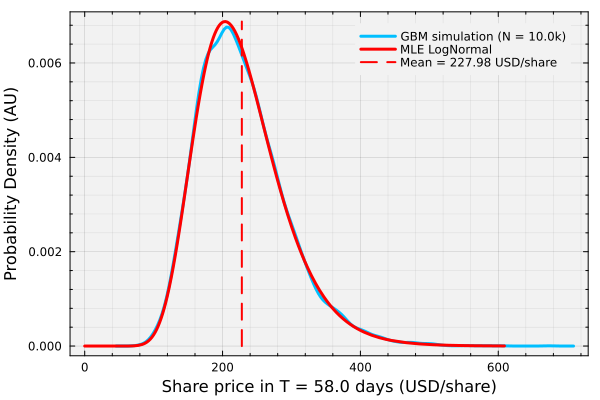

In [27]:
let

    # setup the mean line (for plotting) -
    DTE = metadata["DTE"] |> x-> parse(Float64, x); # days to expiration (units: days)
    LX = ones(100) .* mean(d_gbm);
    LY = range(0, stop = maximum(pdf.(d_gbm, range(quantile(d_gbm,0.01), stop=quantile(d_gbm,0.99), length=100))), length = 100) |> collect;

    # plot -
    density(endpoint_samples, lw=3, c=:deepskyblue1, label="GBM simulation (N = $(length(endpoint_samples)/1000)k)")
    plot!(d_gbm, lw=3, label="MLE LogNormal", c=:red, 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent, xminorticks=true, xminorgrid = true, yminorgrid = true)
    
    plot!(LX, LY, lw=2, ls=:dash, c=:red, label="Mean = $(round(mean(d_gbm),digits=2)) USD/share")
    xlabel!("Share price in T = $(DTE) days (USD/share)", fontsize=18)
    ylabel!("Probability Density (AU)", fontsize=18)
end

### Model 2: Future share price projection using the Implied Volatility
Alternatively, we could use the implied volatility to estimate the expected share price move over some time $0\rightarrow{T}$.
Suppose we construct a [Normal distribution](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Normal) $\mathcal{N}(\mu_{IV},\sigma_{IV})$ where mean $\mu_{IV} = S_{\circ}\exp(\bar{r}\cdot{T\Delta{t}})$, i.e., the risk-neutral future value of the current share price, or just $\mu_{IV}\approx{S}_{\circ}$ for short duration contracts, and standard deviation $\sigma_{IV}$ is:
$$
\sigma_{IV} = S_{\circ}\cdot\left(\frac{\text{IV}}{100}\right)\cdot\sqrt{\text{T}\cdot\Delta{t}}
$$
using the [Normal type exported by the Distributions.jl package](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Normal). 
 > __Note__ In the expression above, the `IV` is given as a percentage `X.Y%.` If we already have a decimal, then do __not__ divided by `100.`

This is only an approximate model of the future share price. However, this model is widely used to generate quick estimates of future share price ranges using the forward-looking implied volatility `IV.`  Let's save the Normal IV distribution distribution $\mathcal{N}(\mu_{IV},\sigma_{IV})$ in the `d_IV` variable (don't forget to use $\bar{\sigma}$ for the implied volatility, as a decimal):

In [28]:
d_IV = Normal(Sₒ*exp(risk_free_rate*DTE*Δt), Sₒ*(σ̄)*sqrt(DTE*Δt));

`Unhide` the code block below to see how we plotted the `d_gbm::LogNormal` and `d_IV::Normal` future share price densities at `T = 58 days`.  

> __What do we see?__ The log-normal GBM share price distribution (blue line) is right-skewed and cannot admit negative share prices. However, the Normal IV distribution (red line) is symmetric around the future share price and can admit negative share prices, albeit with a small probability.

How do the two distributions compare?

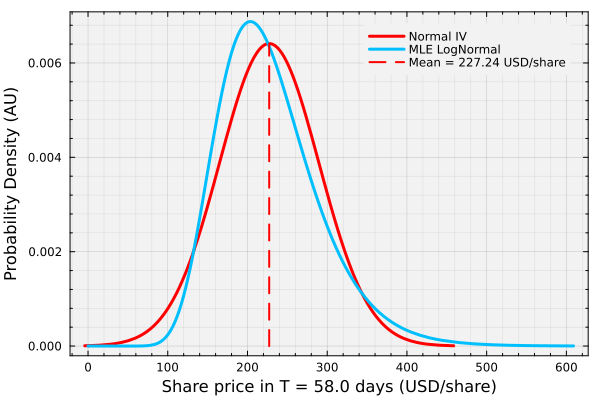

In [29]:
let

    # initialize -
    DTE = metadata["DTE"] |> x-> parse(Float64, x); # days to expiration (units: days)
    LX = ones(100) .* mean(d_IV);
    LY = range(0, stop = maximum(pdf.(d_IV, range(quantile(d_IV,0.01), stop=quantile(d_IV,0.99), length=100))), length = 100) |> collect;

    plot(d_IV, lw=3, label="Normal IV", c=:red, 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent, xminorticks=true, minorgrid = true);
    plot!(d_gbm, lw=3, label="MLE LogNormal", c=:deepskyblue1)
    plot!(LX, LY, lw=2, ls=:dash, c=:red, label="Mean = $(round(mean(d_IV),digits=2)) USD/share")
    
    xlabel!("Share price in T = $(DTE) days (USD/share)", fontsize=18)
    ylabel!("Probability Density (AU)", fontsize=18)
end

In [30]:
do_I_see_the_share_price_plot = true; # set this value {true | false}

### Probability of Profit at Expiration
In this step, we'll estimate [the cumulative distribution function (CDF)](https://en.wikipedia.org/wiki/Cumulative_distribution_function) for the geometric Brownian motion and implied volatility share price distributions. 
We can query the cumulative distribution function $F_{S}(\star)$ using for the projected geometric Brownian motion distribution `d_gbm` and the Implied Volatility price distribution `d_IV` using [the `cdf(...)` function exported by the Distributions.jl package](https://github.com/JuliaStats/Distributions.jl?tab=readme-ov-file).

> __Refresher on Cumulative Probability Functions__
> 
> Let's do a quick refresher on what the cumulative probability distribution function tells us. The cumulative distribution function of a real-valued random variable $X$ (this is share price at expiration in our case) is given by:
> $$
\begin{align*}
P(X\leq{x}) &= F_{X}(x)
\end{align*}
$$
> that is, the probability that we see a value for the random variable $X$ less than or equal to the specified value $x$ is the cumulative distribution function evaluated at $x$. Alternatively, $P(X>x)$ is given by:
> $$
\begin{align*}
P(X>{x}) &= 1 - F_{X}(x)
\end{align*}
$$
> Lastly, the probability that $X$ (share price at expiration) lies in the interval $(a,b]$, where $a < b$ is given by:
>$$
\begin{align*}
P(a < X \leq b) &= F_{X}(b) - F_{X}(a)
\end{align*}
$$

In [Julia we can use the `cdf(...)` function exported from the Distributions.jl package](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.cdf-Tuple{UnivariateDistribution,%20Real}) to compute $F_{S}\left(x\right)$.

#### Visualize CDF
Let's use our `d_gbm` and `d_IV` distribution models to visualize the cumulative distribution function for share price of `MU` at contract expiration.

`Unhide` the code block below to see how we plotted the cumulative distribution function (CDF) for `MU` share price at contract expiration using the risk-neutral geometric Brownian motion `d_gbm` and IV-based price distributions `d_IV.` 

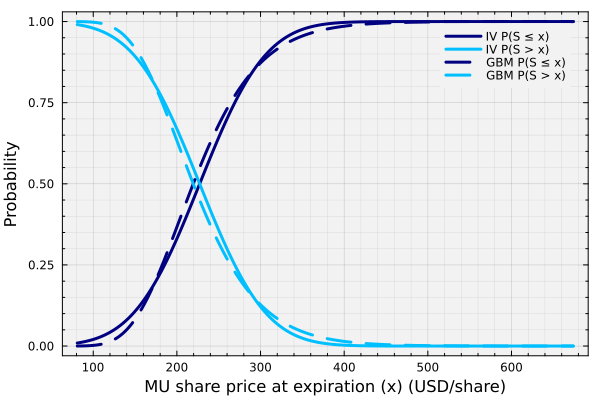

In [31]:
X = let
    number_of_samples = length(endpoint_samples);
    X = Array{Float64,2}(undef, number_of_samples, 3);
    S = Array{Float64,1}();
    for i ∈ eachindex(endpoint_samples)
        push!(S,endpoint_samples[i]);
    end
    S = sort(S);
    
    for i ∈ eachindex(S)
    
        X[i,1] = S[i];
        X[i,2] = cdf(d_gbm, S[i]);
        X[i,3] = cdf(d_IV, S[i]);
    end

    plot(X[:,1], X[:,3], lw=3, c=:navy, label="IV P(S ≤ x)", xminorticks=5, yminorticks=5, bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent, minorgrid = true)
    plot!(X[:,1], 1 .- X[:,3], lw=3, c=:deepskyblue1, label="IV P(S > x)")

    plot!(X[:,1], X[:,2], lw=3, c=:navy, label="GBM P(S ≤ x)", xminorticks=5, yminorticks=5, ls=:dash)
    plot!(X[:,1], 1 .- X[:,2], lw=3, c=:deepskyblue1, label="GBM P(S > x)", ls=:dash)

    xlabel!("MU share price at expiration (x) (USD/share)", fontsize=18);
    ylabel!("Probability", fontsize=18);
end

In [32]:
do_I_see_the_CDF_plot = true; # set this value {true | false}

From the CDF curves, what is the (approximate) probability that `MU` shares will close _below_ `90 USD/share` at expiration (use the GBM curve)?

In [33]:
estimated_probability_of_90_USD_per_share_at_expiration = 0.70; # fill in an estimate

### Probability of Various Outcomes
Now that we have our cumulative distributions, we can compute the probability of observing various scenarios. Let's consider three scenarios.

__Scenario 1: Probability of downside loss__. In this scenario, the share price at expiration $S_{T}$ is at least $\epsilon$ _below_ the downside breakeven point $B^{-}$, assuming $\epsilon \geq $ `0.01` USD/share. The probability of this scenario occurring is given by $P(S_{T}\leq{B^{-}} - \epsilon) = F_{S}\left(B^{-} - \epsilon\right)$.

In [34]:
p_downside_loss_gbm, p_downside_loss_IV = let

    # initialize 
    ϵ = 0.01; # 1/100 USD
    p_downside_loss_gbm = nothing;
    p_downside_loss_IV = nothing;

    # compute P(S < B_low -  ϵ) for the GBM and IV models
    p_downside_loss_gbm = cdf(d_gbm,B_low-ϵ);
    p_downside_loss_IV = cdf(d_IV,B_low-ϵ);

    # return data -
    p_downside_loss_gbm, p_downside_loss_IV
end

(0.02129071670620236, 0.05166729297396653)

In [35]:
println("Scenario 1: Probability (GBM,IV) = ($(p_downside_loss_gbm),$(p_downside_loss_IV))")

Scenario 1: Probability (GBM,IV) = (0.02129071670620236,0.05166729297396653)


__Scenario 2: Probability of upside loss__. In this scenario, the share price at expiration $S_{T}$ is at least $\epsilon$ _above_ the upside breakeven point $B^{+}$, assuming $\epsilon \geq $ `0.01` USD/share. The probability of this scenario occurring is given by $P(S_{T}>B^{+} + \epsilon) = 1 - F_{S}\left(B^{+} + \epsilon\right)$.

In [36]:
p_upside_loss_gbm, p_upside_loss_IV = let

    # initialize 
    ϵ = 0.01; # 1/100 USD
    p_upside_loss_gbm = nothing;
    p_upside_loss_IV = nothing;

    # compute P(S > B_high +  ϵ) for the GBM and IV models
    p_upside_loss_gbm = 1 - cdf(d_gbm,B_high+ϵ);
    p_upside_loss_IV = 1 - cdf(d_IV,B_high+ϵ);

    # return data -
    p_upside_loss_gbm, p_upside_loss_IV
end;

In [37]:
println("Scenario 2: Probability (GBM,IV) = ($(p_upside_loss_gbm),$(p_upside_loss_IV))")

Scenario 2: Probability (GBM,IV) = (0.09584708499995886,0.08135303689492557)


__Scenario 3: Maximum profit__. In this scenario, the share price at expiration $S_{T}$ is between the strike prices $K_{1}$ and $K_{2}$. The probability of this scenario occurring is given by $P(K_{1} < S_{T} \leq{K_{2}}) = F_{S}\left(K_{2}\right) - F_{S}\left(K_{1} + \epsilon \right)$, assuming $\epsilon \geq $ `0.01` USD/share.

In [38]:
p_max_profit_gbm, p_max_profit_IV = let

    # initialize -
    ϵ = 0.01; # 1/100 USD
    p_max_profit_gbm = nothing;
    p_max_profit_IV = nothing;
    K₁ = put_contract_model.K;
    K₂ = call_contract_model.K;

    # compute the probability P(S_low < S_{T} ≤ S_high) for the GBM and IV
    p_max_profit_gbm = cdf(d_gbm,K₂) - cdf(d_gbm,K₁+ϵ);
    p_max_profit_IV = cdf(d_IV,K₂) - cdf(d_IV,K₁+ϵ);

    # return data -
    p_max_profit_gbm, p_max_profit_IV
end;

In [39]:
println("Scenario 3: Probability of maximum profit (GBM,IV) = ($(p_max_profit_gbm),$(p_max_profit_IV))")

Scenario 3: Probability of maximum profit (GBM,IV) = (0.8676842809860802,0.8491733937256466)


#### Probability of profit (POP) table
`Unhide` the code block below to see how we developed a table displaying the probability of profit calculations for an `MU` put option using the risk-neutral geometric Brownian motion `d_gbm` and IV-based price distributions `d_IV.` 

__Summary__: For each random combination of `MU` call and put contracts, the maximum profit and the probability of the various outcomes will change. However, if you rerun the notebook a few times, some interesting patterns emerge. 

In [58]:
let 
    
    # initialize -
    table_df = DataFrame()
    ϵ = 0.01;
    σ̄ = (1/2)*(call_leg_data[:IV] + put_leg_data[:IV]);

    # GBM row -
    gbm_row = (
        model="GBM",
        Sₒ = Sₒ,
        σ = σ̄,
        DTE = DTE,
        put_K₁ = put_contract_model.K,
        call_K₂ = call_contract_model.K,
        width = call_contract_model.K - put_contract_model.K,
        max_profit = (call_contract_model.premium + put_contract_model.premium),
        p_max_profit = p_max_profit_gbm,
        p_downside_loss = p_downside_loss_gbm,
        p_upside_loss = p_upside_loss_gbm,
        p_total = (p_max_profit_gbm + p_downside_loss_gbm + p_upside_loss_gbm)
    );
    push!(table_df, gbm_row);

    # IV row -
    IV_row = (
        model="IV",
        Sₒ = Sₒ,
        σ = σ̄,
        DTE = DTE,
        put_K₁ = put_contract_model.K,
        call_K₂ = call_contract_model.K,
        width = call_contract_model.K - put_contract_model.K,
        max_profit = (call_contract_model.premium + put_contract_model.premium),
        p_max_profit = p_max_profit_IV,
        p_downside_loss = p_downside_loss_IV,
        p_upside_loss = p_upside_loss_IV,
        p_total = (p_max_profit_gbm + p_downside_loss_gbm + p_upside_loss_gbm)
    );
    push!(table_df, IV_row);
    
    # make a table -
   pretty_table(
         table_df;
         fit_table_in_display_horizontally = false,
         backend = :text,
         table_format = TextTableFormat(borders = text_table_borders__compact)
    );
end

 -------- --------- --------- --------- --------- --------- --------- ------------ -------------- ----------------- --------------- ----------
   model        Sₒ         σ       DTE    put_K₁   call_K₂     width   max_profit   p_max_profit   p_downside_loss   p_upside_loss    p_total 
  String   Float64   Float64   Float64   Float64   Float64   Float64      Float64        Float64           Float64         Float64    Float64 
 -------- --------- --------- --------- --------- --------- --------- ------------ -------------- ----------------- --------------- ----------
     GBM    225.78   0.69135      58.0     130.0     310.0     180.0          4.1       0.867684         0.0212907       0.0958471   0.984822
      IV    225.78   0.69135      58.0     130.0     310.0     180.0          4.1       0.849173         0.0516673        0.081353   0.984822
 -------- --------- --------- --------- --------- --------- --------- ------------ -------------- ----------------- --------------- ----------


In [55]:
do_I_see_the_POP_table = true; # set this value {true | false}

### Discussion Questions

___

## Summary
We demonstrated how to construct and analyze a short strangle options strategy using real market data, combining analytical calculations with probabilistic modeling to assess risk and potential outcomes.

> __Key Takeaways:__
> 
> * The short strangle profit diagram exhibits a characteristic profile with maximum profit occurring when the share price at expiration falls between the two strike prices, and losses occurring when the share price moves significantly beyond either breakeven point.
> * Breakeven points for a short strangle are calculated analytically, where the lower breakeven equals the put strike price minus the total premiums collected from both legs, and the upper breakeven equals the call strike price plus the total premiums collected from both legs, defining the boundaries between profitable and unprofitable regions at expiration.
> * The cumulative distribution function enables quantitative probability estimates for different outcome scenarios, with the geometric Brownian motion model producing a log-normal distribution and the implied volatility model producing a normal distribution, each offering different perspectives on future price ranges and associated probabilities.

This approach shows how options contracts can be combined to create positions with specific risk-reward profiles, and how probabilistic models provide forward-looking estimates of strategy performance under different market conditions.
___

## Tests
In the code block below, we check some values in your notebook and give you feedback on which items are correct or different. `Unhide` the code block below (if you are curious) about how we implemented the tests and what we are testing.

In [ ]:
let 
    @testset verbose = true "CHEME 5660 problem set 5 test suite" begin

        @testset "Task 1: Call and Put contract data" begin
            @test @isdefined(put_contracts)
            @test @isdefined(call_contracts)
            @test !isempty(put_contracts)
            @test !isempty(call_contracts)
            @test @isdefined(call_leg_data)
            @test @isdefined(put_leg_data)
        end

        @testset "Task 2: Build Contract models, profit diagram and breakeven" begin
            @test @isdefined(put_contract_model)
            @test @isdefined(call_contract_model)
            @test isa(put_contract_model, MyAmericanPutContractModel)
            @test isa(call_contract_model, MyAmericanCallContractModel)
            @test @isdefined(share_price_array)
            @test !isempty(share_price_array)
            @test @isdefined(profit_array)
            @test !isempty(profit_array)
            @test @isdefined(B_low)
            @test @isdefined(B_high)
            @test isa(B_low, Number)
            @test isa(B_high, Number)
            @test B_low < B_high
            @test do_I_see_the_profit_loss_plot == true
        end

        @testset "Task 3: POP calculations" begin
            @test @isdefined(gbm_model)
            @test @isdefined(σ̄)
            @test isa(gbm_model, MyGeometricBrownianMotionEquityModel)
            @test isa(σ̄, Number)
            @test σ̄ > 0
            @test @isdefined(endpoint_samples)
            @test !isempty(endpoint_samples)
            @test @isdefined(d_gbm)
            @test @isdefined(d_IV)
            @test do_I_see_the_share_price_plot == true
            @test do_I_see_the_CDF_plot == true
            @test @isdefined(estimated_probability_of_90_USD_per_share_at_expiration)
            @test isa(estimated_probability_of_90_USD_per_share_at_expiration, Number)
            @test @isdefined(X)
            @test !isempty(X)
            @test do_I_see_the_POP_table == true
            @test @isdefined(p_downside_loss_gbm)
            @test @isdefined(p_downside_loss_IV)
            @test @isdefined(p_upside_loss_gbm)
            @test @isdefined(p_upside_loss_IV)
            @test @isdefined(p_max_profit_gbm)
            @test @isdefined(p_max_profit_IV)
            @test isa(p_downside_loss_gbm, Number)
            @test isa(p_downside_loss_IV, Number)
            @test isa(p_upside_loss_gbm, Number)
            @test isa(p_upside_loss_IV, Number)
            @test isa(p_max_profit_gbm, Number)
            @test isa(p_max_profit_IV, Number)
            @test 0 ≤ p_downside_loss_gbm ≤ 1
            @test 0 ≤ p_downside_loss_IV ≤ 1
            @test 0 ≤ p_upside_loss_gbm ≤ 1
            @test 0 ≤ p_upside_loss_IV ≤ 1
            @test 0 ≤ p_max_profit_gbm ≤ 1
            @test 0 ≤ p_max_profit_IV ≤ 1
        end 

        @testset "Questions" begin
            # @test did_I_answer_question_0 == true
            # @test did_I_answer_question_1 == true
            # @test did_I_answer_question_2 == true
            # @test did_I_answer_question_3 == true
        end
    end
end;

Questions: Test Failed at /Users/jdv27/Desktop/julia_work/PS-5660-F25/PS5-CHEME-5660-TEMPLATE-F25/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_Y122sZmlsZQ==.jl:68
  Expression: did_I_answer_question_0 == true
   Evaluated: false == true

Stacktrace:
 [1] top-level scope
   @ ~/Desktop/julia_work/PS-5660-F25/PS5-CHEME-5660-TEMPLATE-F25/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_Y122sZmlsZQ==.jl:4
 [2] macro expansion
   @ ~/.julia/juliaup/julia-1.12.1+0.aarch64.apple.darwin14/share/julia/stdlib/v1.12/Test/src/Test.jl:1776 [inlined]
 [3] macro expansion
   @ ~/Desktop/julia_work/PS-5660-F25/PS5-CHEME-5660-TEMPLATE-F25/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_Y122sZmlsZQ==.jl:68 [inlined]
 [4] macro expansion
   @ ~/.julia/juliaup/julia-1.12.1+0.aarch64.apple.darwin14/share/julia/stdlib/v1.12/Test/src/Test.jl:1776 [inlined]
 [5] macro expansion
   @ ~/Desktop/julia_work/PS-5660-F25/PS5-CHEME-5660-TEMPLATE-F25/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_Y122sZmls

Test.TestSetException: Some tests did not pass: 54 passed, 4 failed, 0 errored, 0 broken.

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.